<a href="https://www.kaggle.com/code/szeyeung/feature-engineering-medical-cost?scriptVersionId=101239047" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# How Feature Engineering Can Greatly Improved Model Predictions: The Case of Medical Insurance Cost

When tackling a data science problem, many learners are tempted to chase for complex and sophisticated machine learning algorithms, and concentrate their efforts in using different algorithms and tuning hyperparameters, and let the modeling algorithms do the job of understanding the hidden logic behind the data. While many machine learning models are very good in picking up patterns, sometimes a smart tweaking of features based on discovery of critical structures in exploratory data analysis can bring a big breakthrough in model performance, no matter which algorithm is used. It is the case for this relatively simple but tricky dataset.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


In [2]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


# The Dataset

In [3]:
# loading dataset
dataset = pd.read_csv('../input/insurance/insurance.csv')
dataset

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
dataset.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


The dataset, which is cited in Brett Lantz’s book “Machine Learning with R”, has only 7 columns: age, sex, bmi, smoker or not, number of children, region and finally the medical insurance charges, which is the dependent variable to be predicted. The dataset is clean, with no missing value, and contains 1,338 records.

# The 3 Tiers Charging Structure

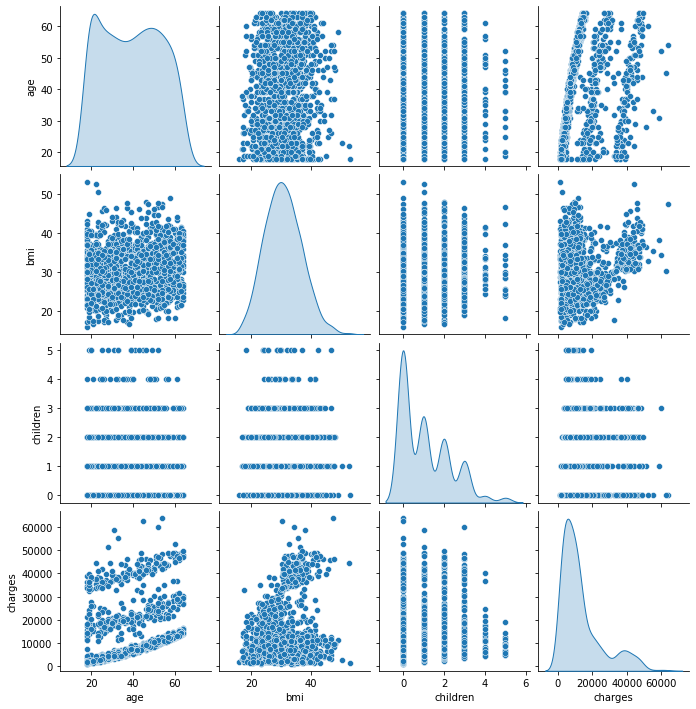

In [5]:
sns.pairplot(dataset[['age', 'bmi', 'children', 'charges']], diag_kind='kde')

The pairplot of numerical features reveals some interesting things. First the scatterplot of charges against age shows a 3 tiers structure, most data points concentrated into three roughly parallel uprising clusters. Secondly the scatterplot of charges against bmi also has some strange shape. Before further exploring, let's have a look at the general shape of the categorical features first.

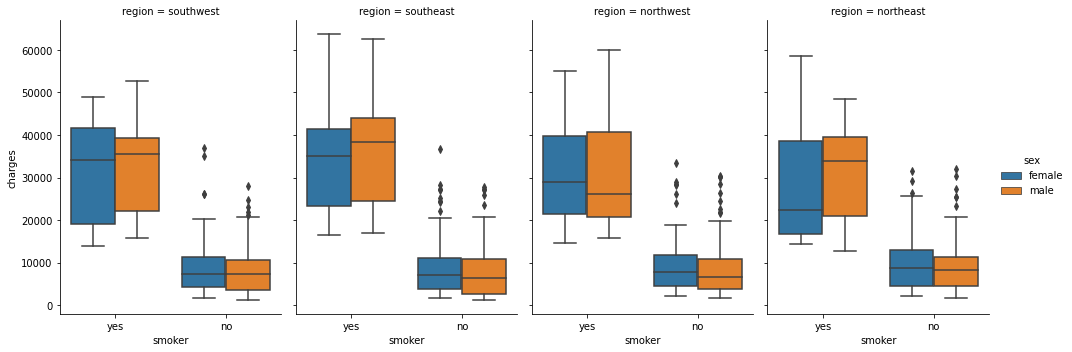

In [6]:
sns.catplot(x='smoker', y='charges', hue='sex',
            col='region', aspect=.7,
            kind='box', data=dataset)

The boxplots of distributions of charges of different sexes, smokers and non-smokers in different regions reveals that, although different regions have variation of mean values, they are following the same pattern, with smokers have much larger charges, while most non-smokers have lower charges, there are notable numbers of outlying cases.

Now we go back to the scatterplots to see how smoking affects health insurance costs.

<AxesSubplot:xlabel='age', ylabel='charges'>

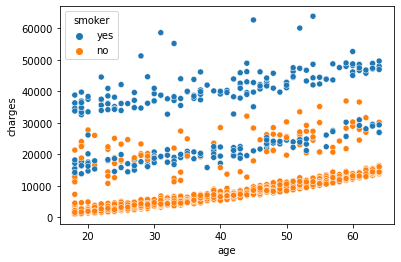

In [7]:
sns.scatterplot(data=dataset, x='age', y='charges', hue='smoker')

Perhaps as expected, the scatterplot of charges against age with smokers and non-smokers separated shows that the high charges tier consists of smokers, the low charges tier of non-smokers, and the middle tier has a mixture of both groups.

<AxesSubplot:xlabel='bmi', ylabel='charges'>

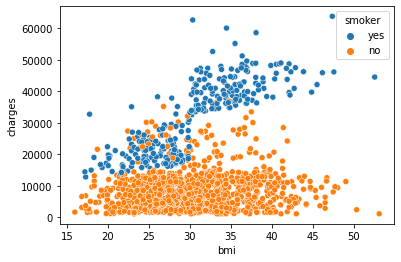

In [8]:
sns.scatterplot(data=dataset, x='bmi', y='charges', hue='smoker')

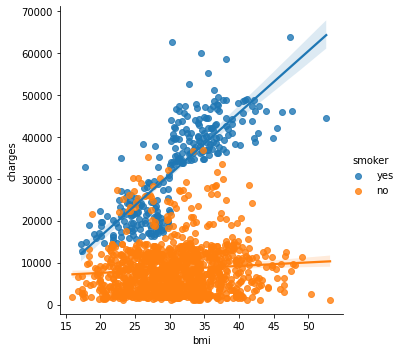

In [9]:
sns.lmplot(data=dataset, x='bmi', y='charges', hue='smoker')

The separation of smokers and non-smokers in the charges against bmi scatterplot reveals something which is even more interesting: The cluster of smokers forms a butterfly shape. Many people are tempted to think smokers and non-smokers form two linear regression lines of very different slopes. But if we look closer into the smokers cluster, instead of seeing it as a gradual increase of healthcare charges corresponding to bmi, perhaps it looks closer to a ruptured fault, before it the charges vary around 20k, after it they jump a step to around 40k. And the demarcation line, bmi=30, is exactly the line defining who are obese. So it will be useful to make obese a new feature, and further divide the smokers and non-smokers groups into obese and not obese.

In [10]:
df=dataset.copy()

# create the obese feature
df['obese']=df['bmi'].map(lambda x: 1 if x > 30 else 0)

# encode the features of sex and smoker into numbers
df['sex'] = df['sex'].map({'female': 0, 'male': 1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})

#further derive features marking obese smokers, not-obese smokers, obese-non-smoker and not-obese-non-smoker
df['obese_smoker']=df.apply( lambda r: 'not-obese-non-smoker' if ((r['smoker']==0) & (r['obese']==0)) 
                            else ('obese-smoker' if ((r['smoker']==1) & (r['obese']==1)) 
                                  else ('obese-non-smoker' if ((r['smoker']==0) & (r['obese']==1)) 
                                        else 'not-obese-smoker')), axis=1)
df

,age,sex,bmi,children,smoker,region,charges,obese,obese_smoker
0,19,0,27.900,0,1,southwest,16884.92400,0,not-obese-smoker
1,18,1,33.770,1,0,southeast,1725.55230,1,obese-non-smoker
2,28,1,33.000,3,0,southeast,4449.46200,1,obese-non-smoker
3,33,1,22.705,0,0,northwest,21984.47061,0,not-obese-non-smoker
4,32,1,28.880,0,0,northwest,3866.85520,0,not-obese-non-smoker
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,northwest,10600.54830,1,obese-non-smoker
1334,18,0,31.920,0,0,northeast,2205.98080,1,obese-non-smoker
1335,18,0,36.850,0,0,southeast,1629.83350,1,obese-non-smoker
1336,21,0,25.800,0,0,southwest,2007.94500,0,not-obese-non-smoker


<AxesSubplot:xlabel='age', ylabel='charges'>

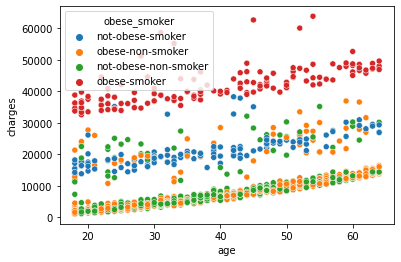

In [11]:
sns.scatterplot(data=df, x='age', y='charges', hue='obese_smoker')

Further division of smokers group does show that obese smokers nearly exclusively form the high charges tier, and most of the not obese smokers occupy the middle tier. On the other hand, obesity does not have the same effect for non smokers, we can see perhaps there are more or less the same number of obese and not obese non smokers in the lower tier and middle tier. And the straight regression lines of these groups do not look fit very well with the clusters, indicating within each cluster, age does not exactly have a linear relation with charges, uprising curves may fit better.

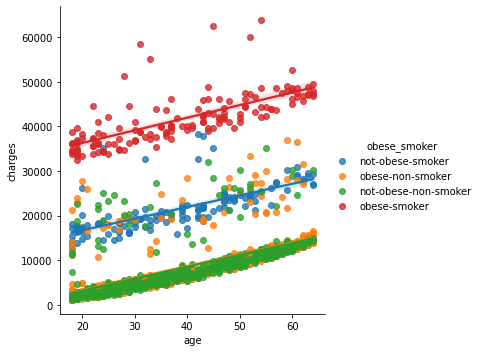

In [12]:
sns.lmplot(data=df, x='age', y='charges', hue='obese_smoker')

And in the charges against bmi scatterplot, the separation of obese and not obese smokers clearly shows a pair of stepping up regression lines.

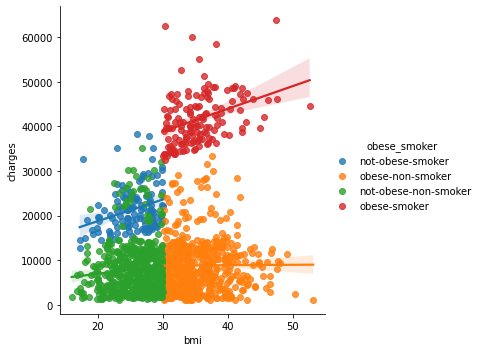

In [13]:
sns.lmplot(data=df, x='bmi', y='charges', hue='obese_smoker')

But for the non-smokers, there are no clear cut subgroups with other variables, perhaps with the exception that non-smokers with no children tend to concentrate in the lower part of the low charges tier. The outlying scatters in the middle tier apparently cannot be explained by available features in the dataset, perhaps related to other factors like genetic diseases or previous conditions.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='age', ylabel='charges'>

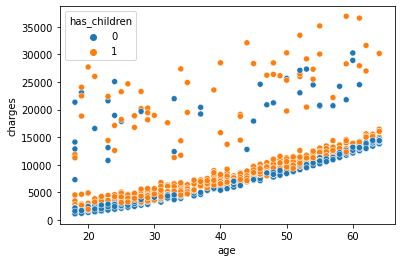

In [14]:
non_smoker=df.loc[df.smoker==0]
non_smoker['has_children']=non_smoker.apply(lambda r: 1 if (r['children'] > 0) else 0, axis=1)
sns.scatterplot(data=non_smoker, x='age', y='charges', hue='has_children')

The final step of preprocessing is to use one-hot encoding to transform the remaining categorical features 'region' and 'obese_smoker' into different columns of binary numerical values. I will leave the features as they are for now, and later will use selections of different features to train the same set of models to illustrate the impact of feature engineering on model performances.

In [15]:
# one-hot encoding of region and obese_smoker features
df = pd.get_dummies(df, columns=['region'])
df = pd.get_dummies(df, columns=['obese_smoker'])
df

,age,sex,bmi,children,smoker,charges,obese,region_northeast,region_northwest,region_southeast,region_southwest,obese_smoker_not-obese-non-smoker,obese_smoker_not-obese-smoker,obese_smoker_obese-non-smoker,obese_smoker_obese-smoker
0,19,0,27.900,0,1,16884.92400,0,0,0,0,1,0,1,0,0
1,18,1,33.770,1,0,1725.55230,1,0,0,1,0,0,0,1,0
2,28,1,33.000,3,0,4449.46200,1,0,0,1,0,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,0,1,0,0,1,0,0,0
4,32,1,28.880,0,0,3866.85520,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,1,0,1,0,0,0,0,1,0
1334,18,0,31.920,0,0,2205.98080,1,1,0,0,0,0,0,1,0
1335,18,0,36.850,0,0,1629.83350,1,0,0,1,0,0,0,1,0
1336,21,0,25.800,0,0,2007.94500,0,0,0,0,1,1,0,0,0


# Making Models

For convenience of coding, I implement both models with the Keras library from Tensorflow. The first linear model is a layer of single linear neuron, which is equivalent to multiple linear regression. The second model is deep neural network(dnn), which has two hidden dense layers of 64 and 128 neurons, all activated by rectified linear units(relu), which are more capable of capturing complex patterns in data. Both models have a normalization layer to normalize the values of each feature, and use mean absolute error(mae) as the metrics for loss minimizing and evaluation. As the codes will be used repeatedly for different sets of features, I put all of them into a function.

In [16]:
def make_models(df):
    # separation of train and test datasets
    train_dataset = df.sample(frac=0.8, random_state=99)
    test_dataset = df.drop(train_dataset.index)

    train_labels = train_dataset.pop('charges')
    test_labels = test_dataset.pop('charges')

    # setting normalization layer
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(train_dataset))

    # setting up single layer of neural network as linear model
    linear_model = tf.keras.Sequential([
        normalizer,
        layers.Dense(units=1)
    ])

    linear_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=10),
        loss='mean_absolute_error', metrics=['MeanAbsoluteError'])
    
    # setting up deep neural network model
    dnn_model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(1)
      ])

    dnn_model.compile(loss='mean_absolute_error', metrics=['MeanAbsoluteError'], optimizer=tf.keras.optimizers.Adam(0.001))

    def train_and_evaluate_model(model):
        # training model using train set
        history = model.fit(
            train_dataset,
            train_labels,
            epochs=100,
            verbose=0,
            # Calculate validation results on 20% of the training data.
            validation_split = 0.2)
        
        # model evaluation and prediction using test set
        loss, mae = model.evaluate(test_dataset, test_labels, verbose=2)
        
        test_predictions = model.predict(test_dataset).flatten()

        # plot predictions
        a = plt.axes(aspect='equal')
        plt.scatter(test_labels, test_predictions)
        plt.xlabel('True values (charges)')
        plt.ylabel('Predictions (charges)')
        lims = [0, 50000]
        plt.xlim(lims)
        plt.ylim(lims)
        _ = plt.plot(lims,lims)
        plt.show()
        
    print('linear model')
    train_and_evaluate_model(linear_model)
    print('dnn model')
    train_and_evaluate_model(dnn_model)
        
        

# Experimenting Using Different Features Sets for Model Training

## The Original Features Set
We begin with the original set of features encoded, the resulting linear and dnn models have maes of around 3,450 and 3,000 respectively. Compared with the mean charges of 13,270, they are decent but not great. The plots of predicted charges against true values show that, while both models do a good job of predicting cases of lower charges, but when the charges go higher than around 15,000, which is about the end of the low charges tier, both models have difficulties in grasping the tiered structure, resulting in groups whose predicted charges are consistently higher or lower than the true values. The dnn model does better in the higher end and has a better score.

2022-07-19 13:24:41.816749: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-19 13:24:41.909511: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


linear model
9/9 - 0s - loss: 3447.3669 - mean_absolute_error: 3447.3669


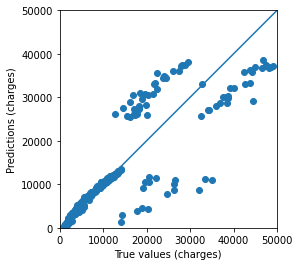

dnn model
9/9 - 0s - loss: 3141.5093 - mean_absolute_error: 3141.5093


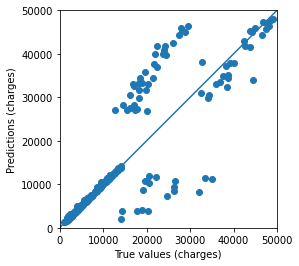

In [17]:
df_original_features=df[['age','sex','bmi','children','smoker','charges','region_northeast','region_northwest','region_southeast','region_southwest']]
make_models(df_original_features)

## Add Obese Feature
Then we add the binary feature ‘obese’ into the features set. The linear model does not get better. But the dnn model gets some benefits from this additional information, which brings the overestimated group closer to their true values of charges, and it’s mae is reduced to around 2,100.

linear model
9/9 - 0s - loss: 3448.9255 - mean_absolute_error: 3448.9255


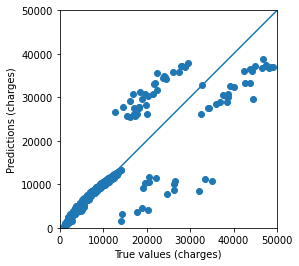

dnn model
9/9 - 0s - loss: 2174.4019 - mean_absolute_error: 2174.4019


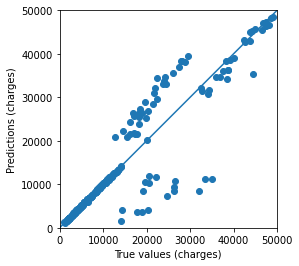

In [18]:
df_add_obese=df[['age','sex','bmi','children','smoker','charges','region_northeast','region_northwest','region_southeast','region_southwest', 'obese']]
make_models(df_add_obese)

## Add Feature Cross of Obese and Smoker
Apparently even with the features of ‘obese’ and ‘smoker’ present, the algorithms need some aids to fully realized the importance of dividing the  ‘obese smoker’, ‘not obese smoker’, ‘obese non-smoker’ and ‘not obese non-smoker’ groups. When we add these four features, both models get a big breakthrough in accuracy. The mae of linear model reduces from around 3,450 to 1,650, and the dnn model from around 2,100 to 1,260. Both models get the majority of predictions closed to the true values, with the exception of the underestimated group. This group is likely the non-smokers who get mid tier charges, which cannot be explained by the features available.

linear model
9/9 - 0s - loss: 1653.6250 - mean_absolute_error: 1653.6250


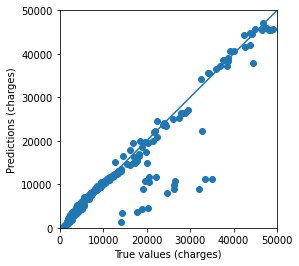

dnn model
9/9 - 0s - loss: 1248.3140 - mean_absolute_error: 1248.3140


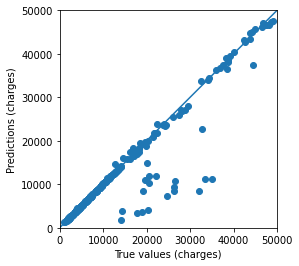

In [19]:
make_models(df)

## Drop Features
With the four derived features at hand, the original features of ‘obese’ and ‘smoker’ may become redundant. How about dropping them from the features set? The performance of the linear model remains more or less the same, but surprisingly the mae of dnn model increases a bit to around 1,300.

linear model
9/9 - 0s - loss: 1643.9017 - mean_absolute_error: 1643.9017


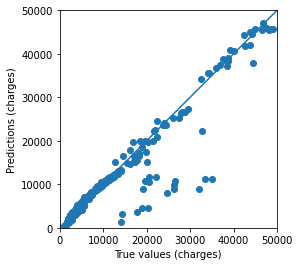

dnn model
9/9 - 0s - loss: 1336.7207 - mean_absolute_error: 1336.7207


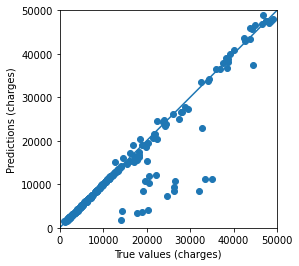

In [20]:
df_drop_obsoletes=df.drop(['smoker','obese'], axis=1)
make_models(df_drop_obsoletes)

And in doing one-hot encoding, many people advise for dropping one column to avoid the problem of multicollinearity in regression. The results of doing it with the addition of dropping the ‘obese’ and ‘smoker’ features, however, does not make notable difference to the linear model, the performace of the dnn model even furthur worsen to around 1,380 mae.

linear model
9/9 - 0s - loss: 1645.5541 - mean_absolute_error: 1645.5541


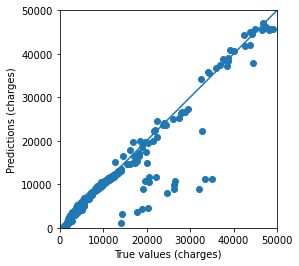

dnn model
9/9 - 0s - loss: 1346.4170 - mean_absolute_error: 1346.4170


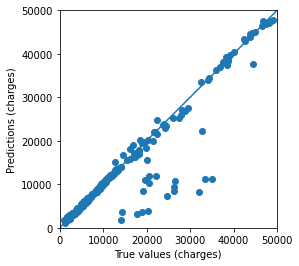

In [21]:
df_drop_more=df.drop(['smoker','obese','region_northeast','obese_smoker_not-obese-non-smoker'], axis=1)
make_models(df_drop_more)

While the features of obese and not obese smokers lead to a big leap of model performance, the two non-smoker group apparently do not make any benefit. Dropping them along with the ‘obese’ and ‘smoker’ features again does not matter much for the linear model, while the mae of the dnn model changes to around 1,340. It seems that the dnn model flavors more than less information, though some of them may be redundant.

linear model
9/9 - 0s - loss: 1651.8284 - mean_absolute_error: 1651.8284


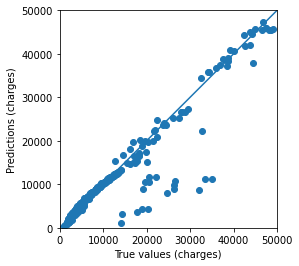

dnn model
9/9 - 0s - loss: 1355.4025 - mean_absolute_error: 1355.4025


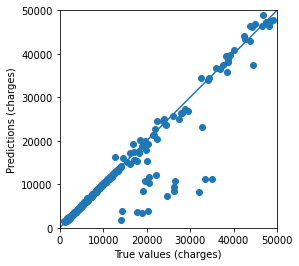

In [22]:
df_drop_more2=df.drop(['obese','smoker','obese_smoker_obese-non-smoker','obese_smoker_not-obese-non-smoker'], axis=1)
make_models(df_drop_more2)

## Age Squared
The final issue follows the observation that the charges against age clusters have a slightly concave upward shape rather than straightly linear. One way to fit this shape is squaring the values of age. It can be done in two ways, either by replacing the original values of the ‘age’ feature with the squared ones, or adding a feature of the squared values. The trials show that both approaches have similar effect: The mae of the linear model can be further reduced to around 1,330, while the mae of the dnn model remains at around 1,260. Seemingly the relu functions of the neurons of the dnn model already capture the shape of the curves.

linear model
9/9 - 0s - loss: 1326.7177 - mean_absolute_error: 1326.7177


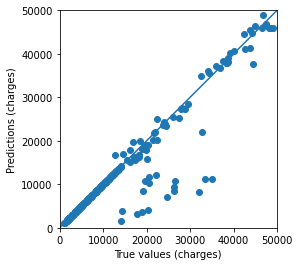

dnn model
9/9 - 0s - loss: 1238.0712 - mean_absolute_error: 1238.0712


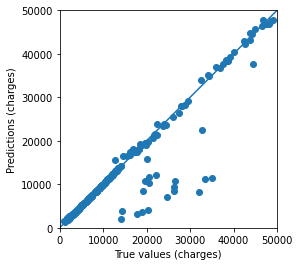

In [23]:
df_age_replaced_by_squared=df.copy()
df_age_replaced_by_squared['age']=df_age_replaced_by_squared['age'].transform(lambda x: x*x)
make_models(df_age_replaced_by_squared)

linear model
9/9 - 0s - loss: 1329.0166 - mean_absolute_error: 1329.0166


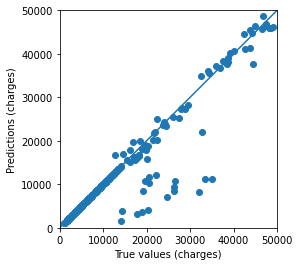

dnn model
9/9 - 0s - loss: 1259.7720 - mean_absolute_error: 1259.7720


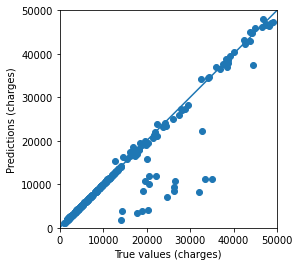

In [24]:
df_add_age_squared=df.copy()
df_add_age_squared['age_squared']=df_add_age_squared['age'].transform(lambda x: x*x)
make_models(df_add_age_squared)

# Conclusion: A Little Tweak in Features Can Have a Big Effect
The above trials show that, with the identification of obesity as a critical factor of this dataset and derive grouping features accordingly, the accuracy of prediction of simple and sophisticated models can have a big improvement. And with the values of ‘age’ feature squared, the performance of a simple multiple linear regression model can be brought close to a deep learning model. They are simple tweaks in features, not involving fancy codings or   rocket science algorithms, just done by observing the data and acting accordingly.